In [1]:
from utils import *
import matplotlib.pyplot as plt
import numpy as np
import difflib
from tqdm import tqdm

import sys
import time

In [2]:
NPOL = 2
OBSNCHAN = 64
NBITS = 8
BLOCSIZE = 134217728
NDIM = int(BLOCSIZE / (OBSNCHAN * NPOL * (NBITS/8)))//2
NDIM

524288

In [3]:
source_file = open("../data/blc04_guppi_57899_53848_DIAG_HIP19849_0002.0000.raw", "rb")

In [4]:
def get_sample_header(file):
    header, h_length, header_dict = read_header(file)
    bleed_data(file, header_dict)
    return header, header_dict

header, header_dict = get_sample_header(source_file)
print(header)

In [5]:
pol_0 = generate_2d_normal((NDIM))/20
pol_1 = generate_2d_normal((NDIM))/20

In [6]:
np.var(pol_0[0]+pol_0[1]*1j)

2.0017806561353972

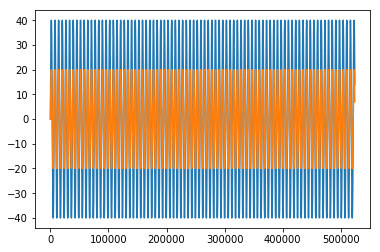

In [7]:
x = np.arange(0, NDIM/1000, 1/1000)
pol_0_real = np.sin(x)*40
pol_0_imag = np.sin(x)*20
plt.plot(pol_0_real)
plt.plot(pol_0_imag)

In [8]:
channel = generate_channel(NDIM, NPOL)
channel[0] += pol_0_real
inds = channel[0] >= 128
channel[0][inds] = 127
channel[1] += pol_0_imag
inds = channel[1] >= 128
channel[1][inds] = 127

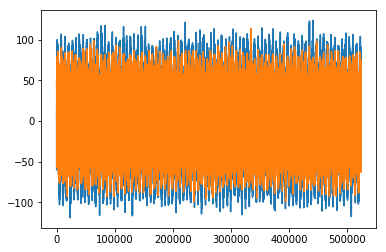

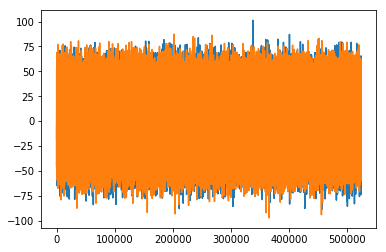

In [9]:
plt.plot(channel[0])
plt.plot(channel[1])
plt.figure()
plt.plot(channel[2])
plt.plot(channel[3])

In [10]:
channel = generate_channel(NDIM, NPOL)
channel = np.array(channel, dtype = np.int8)
channel.T.shape

(524288, 4)

In [11]:
np.var(channel)**0.5

19.593298851435026

In [12]:
# write
with open("sine_and_noise.0000.raw", "wb") as file:
    for i in tqdm(range(128)):
        header, header_dict = get_sample_header(source_file)

        d = {"NPOL": 4, "OBSNCHAN": 64, "NBITS": 8,
             "BLOCSIZE": 134217728, "DIRECTIO": 1,
             "OBSERVER": "'Yuhong Chen'", "SRC_NAME": "'SYNTH'"}
        for key, value in d.items():
            header_dict[key] = value
        d = header_dict
        header = generate_header(d)
        with open("samp_header%d" % i, "wb") as h:
            h.write(header)
        file.write(header)
        for j in range(64):
            channel = generate_channel(NDIM, NPOL)
            if False:
                channel[0] += pol_0_real
                inds = channel[0] >= 128
                channel[0][inds] = 127
                channel[1] += pol_0_imag
                inds = channel[1] >= 128
                channel[1][inds] = 127
            channel = np.array(channel, dtype=np.int8)
            #print("Writing Channel {0} of Data Block {1}".format(j, i), end="\r", flush=True)
            file.write(channel.T.tobytes())
        #print("Finished Writing Data Block {0}     ".format(i), end="\n\r", flush=True)
    print("Done")

100%|██████████| 128/128 [11:40<00:00,  5.42s/it]

Done


In [13]:
np.var(channel[0]*20+channel[1]*20)

5454.882838979305

In [14]:
samp = generate_2d_normal(8*64*1024)
samp.shape

np.mean(samp[0]**2+samp[1]**2)

ch = np.reshape(samp[0] + samp[1]*1j, (8, 64*1024))
ch.shape

spectra = np.fft.fft(ch.T, axis=1)
spectra

rawspec = np.sum(np.abs(spectra)**2, axis=0)
rawspec

np.mean(np.abs(rawspec/(64*1024)))/8

799.3618531627676